<a href="https://colab.research.google.com/github/nicoelbert/vehicleroutingproblem/blob/main/vehicle_routing_solver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Vehicle Routing Problem
vehicle routing problem on complete information using simmulated annealing

#Preparation

In [1]:
#inital run
if True:
  !pip install pulp
  !git clone 'https://github.com/nicoelbert/vehicleroutingproblem'
  %cd vehicleroutingproblem

fatal: destination path 'vehicleroutingproblem' already exists and is not an empty directory.
/content/vehicleroutingproblem


In [2]:
#import packages
import pandas as pd
import sys
import matplotlib.pyplot as plt
from datetime import datetime
import logging

#custom calsses
!git pull
from classes import classes as cl
from functions import functions as fc
from functions import routing as rt

#connect drive for exports
from google.colab import drive
drive.mount('/content/drive')
string_exp_path = "/content/drive/MyDrive/Uni/Seminararbeit Flath/export"


remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 3 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (3/3), done.
From https://github.com/nicoelbert/vehicleroutingproblem
   f902fd9..63c7966  main       -> origin/main
Updating f902fd9..63c7966
Fast-forward
 vehicle_routing_solver.ipynb | 153 +++++++++++++++++++++++--------------------
 1 file changed, 81 insertions(+), 72 deletions(-)
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
logging.basicConfig(filename="logfilename.log", level=logging.INFO)


In [4]:
!git pull
!ls

Already up to date.
classes    logfilename.log  README.md		   vehicle_routing_solver.ipynb
functions  original_data    vehicleroutingproblem


##Data Import

In [5]:
def get_proxdepot(site,plant):
  
  distance_min = 10000000000000
  depot_min = ''
  for d in list_depots:
    distance_ges = rt.get_distance(d,site) + rt.get_distance(d,plant)
    if distance_ges < distance_min:
      distance_min = distance_ges
      depot_min = d
  return depot_min


In [6]:
#depot masterdata
print("Starting with Data Import at {}".format(fc.get_time()))



#load Masterdata from csv
url = 'https://raw.githubusercontent.com/nicoelbert/vehicleroutingproblem/main/original_data/Depots.csv'
df_depots = pd.read_csv(url)


#load basetable
url = 'https://raw.githubusercontent.com/nicoelbert/vehicleroutingproblem/main/original_data/preparedJobs.csv'
df_jobs_org = pd.read_csv(url)

#create and fill dict_depots

dict_depots = {}
list_depots = []

for index, row in df_depots.iterrows():
  depot = cl.Depot(row['Werk'],row['Werk_lon'],row['Werk_lat'])
  dict_depots[row['Werk']] = depot
  list_depots.append(depot)

print("{} depots created".format(len(dict_depots)))
logging.info("{} depots created".format(len(dict_depots)))


#create and fill plants from df_jobs_org
dict_plants = {}
list_plants = []

list_plant_names = df_jobs_org['Werk'].unique() 

for pn in list_plant_names:
  row = df_jobs_org[df_jobs_org['Werk'] == pn].iloc[0]
  plant = cl.Plant(row.Werk,row.Werk_lon,row.Werk_lat)
  dict_plants[plant.name] = plant
  list_plants.append(plant)

print("{} plants created".format(len(dict_plants)))
logging.info("{} plants created".format(len(dict_plants)))

#create and fill sites from df_jobs_org

dict_sites = {}
list_sites = []

df_sites = df_jobs_org[['plz','lon','lat']].copy()
df_sites.drop_duplicates(inplace=True)


for index, row in df_sites.iterrows():
  site = cl.Site(row.plz,row.lon,row.lat)
  dict_sites[site.name] = site
  list_sites.append(site)


print("{} sites created".format(len(dict_sites)))
logging.info("{} sites created".format(len(dict_sites)))

#create and fill jobs from df_jobs_org


dict_jobs = {}
list_jobs = []
list_emsen_jobs = []

for index, row in df_jobs_org.iterrows():
  plant = dict_plants[row.Werk]
  site_name = str(row.plz) + '/' +str(row.lon) + '/' + str(row.lat)
  site = dict_sites[site_name]
  prox_depot = get_proxdepot(site,plant)
  job = cl.Job(row.id, row.key, plant,row.Maschinentechnik,row.Material,row.Start_clean,(row.Start_clean + row.Werktage), row.Werktage, site, prox_depot )
  dict_jobs[job.name] = job
  list_jobs.append(job)



print("{} jobs created".format(len(dict_jobs)))
logging.info("{} jobs created".format(len(dict_jobs)))

#create list of days
# since the timespan is 1208 days and there are only 895 relevant days lets work with these first

list_days = []


for j in list_jobs: 
  if j.start not in list_days:
    list_days.append(j.start)
  if j.end not in list_days:
    list_days.append(j.end)

list_days.sort()
print("Working with {} relevant days".format(len(list_days)))
logging.info("Working with {} relevant days".format(len(list_days)))

#create one tour for each day and depot

dict_tours = {}
total = 0

for depot in dict_depots:
  dict_tours[depot] = {}

for depot in list_depots:
  for day in list_days:
    dict_tours[depot.name][day] = cl.Tour(depot,day)
  total = total + len(dict_tours[depot.name])

print("{} tours created".format(total))
logging.info("{} tours created".format(total))
    
print("Done with Data Import at {}".format(fc.get_time()))
logging.info("Done with Data Import at {}".format(fc.get_time()))

Starting with Data Import at 21:59:06
15 depots created
8 plants created
6166 sites created
53178 jobs created
Working with 895 relevant days
13425 tours created
Done with Data Import at 21:59:20


Visualize Data


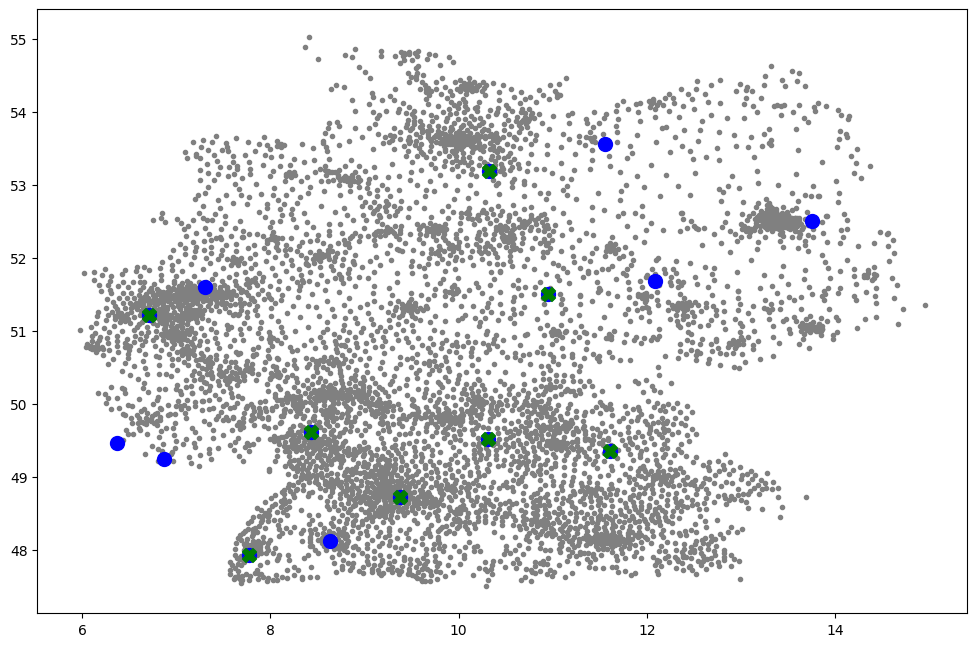

In [7]:
fc.get_map(list_depots,list_plants,list_sites)

Inital Solution

In [9]:
#create inital solution
""" every silo is delivered on the day it is needed and picked up the day it is not needed anymore, the tour swichtes between plant and sites - starting and ending at the depot"""

print("Starting with inital solution at {}".format(fc.get_time()))
logging.info("Starting with inital solution at {}".format(fc.get_time()))

for j in list_jobs: 
  j.dropoff_day = j.start
  j.pickup_day = j.end
  j.dropoff_depot = j.prox_depot
  j.pickup_depot = j.prox_depot

  #assign inital tours
  j.dropoff_tour = dict_tours[j.dropoff_depot.name][j.dropoff_day]
  j.pickup_tour = dict_tours[j.pickup_depot.name][j.pickup_day]

  #insert jobs and plants into tours for dropoff and pickup
  if j not in j.dropoff_tour.list_dropoffs:
    j.dropoff_tour.list_dropoffs.append(j)
  if j.plant not in j.dropoff_tour.list_plants:
    j.dropoff_tour.list_plants.append(j.plant)
  
  if j not in j.pickup_tour.list_pickups:
    j.pickup_tour.list_pickups.append(j)
  if j.plant not in j.pickup_tour.list_plants:
    j.pickup_tour.list_plants.append(j.plant)
  

i_pickups = 0
i_dropoffs = 0
i_multiple_plants = 0

for depot in dict_depots:
  for day in list_days:
   i_pickups = i_pickups + len(dict_tours[depot][day].list_pickups)
   i_dropoffs = i_dropoffs + len(dict_tours[depot][day].list_dropoffs)
   if len(dict_tours[depot][day].list_plants) > 1:
     i_multiple_plants = i_multiple_plants + 1
     print("Warning at Tour from {} and day {} - {} plants listed".format(depot,day,len(dict_tours[depot][day].list_plants)))
     logging.info("Warning at Tour from {} and day {} - {} plants listed".format(depot,day,len(dict_tours[depot][day].list_plants)))
     p_names = []
     for p in dict_tours[depot][day].list_plants:
       p_names.append(p.name)
     print(p_names)


i = 0
total_distance = 0
for depot in dict_depots:
  for day in list_days:
    if len(dict_tours[depot][day].list_plants)>0:
      #rt.routing(dict_tours[depot][day])
      print("Distance for depot {} on day {} is {} - {} done - {} plants detected - t: {}".format(depot,day,dict_tours[depot][day].total_distance,i,len(dict_tours[depot][day].list_plants),fc.get_time()))
      logging.info("Distance for depot {} on day {} is {} - {} done - {} plants detected - t: {}".format(depot,day,dict_tours[depot][day].total_distance,i,len(dict_tours[depot][day].list_plants),fc.get_time()))
      total_distance += dict_tours[depot][day].total_distance
    i = i +1
  

print("There are {} dropoffs and {} pickups listet which creates a difference of {}".format(i_dropoffs,i_pickups,i_dropoffs-i_pickups))
logging.info("There are {} dropoffs and {} pickups listet which creates a difference of {}".format(i_dropoffs,i_pickups,i_dropoffs-i_pickups))
print("Done with inital solution at {} - total distance:".format(fc.get_time(),total_distance)) 
logging.info("Done with inital solution at {} - total distance:".format(fc.get_time(),total_distance)) 

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
Distance for depot Lauterhofen on day 17099 is 0 - 1347 done - 1 plants detected - t: 21:59:44
Distance for depot Lauterhofen on day 17100 is 0 - 1348 done - 1 plants detected - t: 21:59:44
Distance for depot Lauterhofen on day 17101 is 0 - 1349 done - 1 plants detected - t: 21:59:44
Distance for depot Lauterhofen on day 17102 is 0 - 1350 done - 1 plants detected - t: 21:59:44
Distance for depot Lauterhofen on day 17103 is 0 - 1351 done - 1 plants detected - t: 21:59:44
Distance for depot Lauterhofen on day 17104 is 0 - 1352 done - 1 plants detected - t: 21:59:44
Distance for depot Lauterhofen on day 17105 is 0 - 1353 done - 1 plants detected - t: 21:59:44
Distance for depot Lauterhofen on day 17106 is 0 - 1354 done - 1 plants detected - t: 21:59:44
Distance for depot Lauterhofen on day 17107 is 0 - 1355 done - 1 plants detected - t: 21:59:44
Distance for depot Lauterhofen on day 17108 is 0 - 1356 done - 1 plants detect

Persitate Inital Solution

In [10]:

tour_cols = dict_tours['Embsen'][17042].get_colums()

#create df with objects and readable df for solution
i=0
tour_df = pd.DataFrame([tour_cols])
tour_df.columns = tour_cols
tour_df_readable = pd.DataFrame([tour_cols])
tour_df_readable.colums = tour_cols

for depot in dict_depots:
  for day in list_days:
    t = dict_tours[depot][day]
    tour_df.loc[i] = t.get_all_values()
    tour_df_readable.loc[i] = t.get_all_value_readable()



sys.setrecursionlimit(100000)

#export tabular tour data
tour_df.to_csv(string_exp_path + '/tour_df.csv')
tour_df_readable.to_csv(string_exp_path + '/tour_df_readable.csv')


#export all data objects
fc.save_object(dict_depots, string_exp_path +'/dict_depots.pkl')
fc.save_object(dict_sites,  string_exp_path +'/dict_sites.pkl')
fc.save_object(dict_plants, string_exp_path +'/dict_plants.pkl')
fc.save_object(dict_jobs,  string_exp_path +'/dict_jobs.pkl')
fc.save_object(dict_tours,  string_exp_path +'/dict_tours.pkl')
logging.info("objects saved")



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  arr_value = np.array(value)


In [ ]:
dfr

##Backup

In [ ]:
#notes
"""tour contains list of pickup and dropoff node,

"inital solution transport every silo back and forth on a tour prior to the"
"create a tour with list of pickups and list of deliveries - also need to include silo types?"""

In [ ]:
#question
""""really repos or whole problem?"



"how many silos"
"max_km"
"how early"""

In [ ]:
#assumption
"""
max_km? 
max_tour/depot = 1

In [ ]:
#backup

#distance depot,plants
"""
for d in list_depots:
  for p in list_plants:
    print('{} nach {} sind {}'.format(d.name,p.name,fc.get_distance(d,p)))
"""

"""
"eval of sites"
print(len(df_jobs['plz'].unique()))
print(len(df_jobs['lon'].unique()))
print(len(df_jobs['lat'].unique()))
#print(len(df_jobs[['lon','lat']]()))

df_sites = df_jobs[['lon','lat']].copy()

print(df_sites.shape)

df_sites.drop_duplicates(inplace=True)


print(df_sites.shape)
k.key
"""
